<a href="https://colab.research.google.com/github/Pfannen/AI-Stock-Agent/blob/main/notebooks/RL_trading_bot_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install data and TA dependencies
!pip install yahoo_fin
!pip install requests_html
!pip install pandas-ta

# Install RL dependencies
!pip install stable-baselines3 gym-anytrading gym #gym-trading-env

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
from typing import List, Tuple, Callable
import os
from pathlib import Path

# Data and TA imports
import pandas_ta as ta
from yahoo_fin.stock_info import get_data

# RL imports
import gymnasium as gym
import gym_anytrading
#import gym_trading_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3 import A2C
from gym_anytrading.envs import StocksEnv

In [3]:
rl_path = Path("RL/")
model_save_path = rl_path / "models"
os.makedirs(model_save_path, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Basic code for processing data, creating model, training model, and evaluating model performance

In [4]:
# Getting testing data

test_df = get_data(
    ticker="AMZN",
    start_date="12/04/2015",
    end_date="12/04/2023",
    index_as_date=True,
    interval="1d"
)

len(test_df)

1998

In [5]:
# Create a strategy to add certain indicators to data frame

TestStrategy = ta.Strategy(
    name="Test Strategy",
    ta=[
        {"kind": "sma", "length": 10},
        {"kind": "rsi", "length": 10}
    ]
)

# Use strategy on test_df

test_df.ta.strategy(TestStrategy, length=10, append=True)

# Clean test_df

test_df.dropna(inplace=True)

# See data

test_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,open,high,low,close,adjclose,volume,ticker,SMA_10,RSI_10
2015-12-18,33.432499,33.841999,33.206501,33.207001,33.207001,136826000,AMZN,33.20765,47.318114
2015-12-21,33.424999,33.494999,32.946499,33.225498,33.225498,65018000,AMZN,33.18105,47.665665
2015-12-22,33.341499,33.424500,32.963001,33.157501,33.157501,53356000,AMZN,33.11015,46.414972
2015-12-23,33.325001,33.330002,32.831501,33.185001,33.185001,54458000,AMZN,33.10470,47.039427
2015-12-24,33.167500,33.234001,33.029999,33.139500,33.139500,21824000,AMZN,33.10705,46.052776


In [6]:
# Create method to return indicators on given environment

def signals(env):
  start = env.frame_bound[0] - env.window_size
  end = env.frame_bound[1]
  prices = env.df.loc[:, 'close'].to_numpy()[start:end]
  signal_features = env.df.loc[:, ['close', 'volume', 'SMA_10', 'RSI_10']].to_numpy()[start:end]
  return prices, signal_features

# Create custom environment

class CustomEnv(StocksEnv):
  _process_data = signals

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Create test environment

train_end = int(len(test_df) * 0.8)

env = CustomEnv(df=test_df, window_size=10, frame_bound=(10, train_end))
env_lambda = lambda: env
test_vec_env = DummyVecEnv([env_lambda])

In [8]:
# Set up callbacks for storing best model params and stopping when reward is good enough

stop_callback = StopTrainingOnRewardThreshold(reward_threshold=200, verbose=1)
eval_callback = EvalCallback(test_vec_env,
                             callback_on_new_best=stop_callback,
                             eval_freq=10000,
                             best_model_save_path=model_save_path / 'test_model',
                             verbose=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create RL model

test_model = A2C('MlpPolicy', test_vec_env, verbose=1)
test_model.learn(total_timesteps=100000, callback=eval_callback)

In [ ]:
test_model = A2C.load(model_save_path / 'test_model/best_model')

In [ ]:
env = CustomEnv(df=test_df, window_size=10, frame_bound=(train_end, len(test_df)))
obs = env.reset()[0]

while True:
  action, _states = test_model.predict(obs)
  obs, rewards, terminated, truncated, info = env.step(action)
  done = terminated or truncated
  if done:
    print("info", info)
    break

In [ ]:
plt.figure(figsize=(15,6), facecolor='w')
plt.cla()
env.render_all()
plt.show()

# Modular code

## What to create:
* Class for storing base stock data and providing functionality to apply TA functions and return a new data frame
* Class to create and train a model and plot its performance



## StockData Class

In [10]:
class StockData():
  def __init__(self,
              ticker: str,
              start_date: str,
              end_date: str,
              interval: str):
    self.ticker = ticker
    self.start_date = start_date
    self.end_date = end_date
    self.interval = interval
    stock_df = get_data(ticker=ticker,
                        start_date=start_date,
                        end_date=end_date,
                        index_as_date=True,
                        interval=interval)
    self.stock_df = stock_df.drop("ticker", axis=1)

  def add_indicators_to_data(self, indicators: List[Callable[[pd.DataFrame], Tuple[List, str]]]) -> pd.DataFrame:
    df_copy = self.stock_df.copy()
    for indicator in indicators:
      col_data, col_name = indicator(df_copy)
      if len(col_data) == len(df_copy):
        df_copy[col_name] = col_data
    df_copy.dropna(inplace=True)
    return df_copy


### Test out StockData

In [11]:
StockTest = StockData(ticker="AMZN",
                      start_date="12/04/2015",
                      end_date="12/04/2023",
                      interval="1d")

In [ ]:
indicator_test = lambda df: (ta.sma(close=df['close'], length=10), "SMA_10")
new_df = StockTest.add_indicators_to_data(indicators=[indicator_test])
new_df.head()

## ModelBuilder Class

In [13]:
# Create method to return indicators on given environment

def signals(env):
  start = env.frame_bound[0] - env.window_size
  end = env.frame_bound[1]
  prices = env.df.loc[:, 'close'].to_numpy()[start:end]
  signal_features = env.df.to_numpy()[start:end]
  return prices, signal_features

# Create custom environment

class CustomEnv(StocksEnv):
  _process_data = signals

In [14]:
class ModelBuilder():
  def __init__(self, df, window_size, train_percentage, eval_callback_freq, model_save_path):
    self.df = df
    self.window_size = window_size
    self.train_end = int(train_percentage * len(df))
    self.model_save_path = model_save_path
    env = CustomEnv(df=df, window_size=window_size, frame_bound=(window_size, self.train_end))
    env_lambda = lambda: env
    self.env = DummyVecEnv([env_lambda])

    self.stop_callback = StopTrainingOnRewardThreshold(reward_threshold=200, verbose=1)
    self.eval_callback = EvalCallback(self.env,
                                      callback_on_new_best=self.stop_callback,
                                      eval_freq=eval_callback_freq,
                                      best_model_save_path=model_save_path,
                                      verbose=1)
    self.model = A2C('MlpPolicy', self.env, verbose=1)

  def train_model(self, timesteps):
    self.model.learn(total_timesteps=timesteps, callback=self.eval_callback)
    self.model = A2C.load(self.model_save_path / 'best_model')

  def test_model(self, frame_bound=None):
    if frame_bound == None:
      frame_bound = (self.train_end, len(self.df))
    test_env = CustomEnv(df=self.df, window_size=self.window_size, frame_bound=frame_bound)
    obs = test_env.reset()[0]

    while True:
      action, _states = self.model.predict(obs)
      obs, rewards, terminated, truncated, info = test_env.step(action)
      done = terminated or truncated
      if done:
        print("info", info)
        break

    plt.figure(figsize=(15,6), facecolor='w')
    plt.cla()
    test_env.render_all()
    plt.show()

### Test out ModelBuilder

In [15]:
TestModelBuilder = ModelBuilder(df=new_df,
                                window_size=10,
                                train_percentage=0.8,
                                eval_callback_freq=5000,
                                model_save_path=model_save_path / 'test_model')

Using cuda device


In [ ]:
TestModelBuilder.train_model(5000)

info {'total_reward': -26.713027954101562, 'total_profit': 0.24886789254238006, 'position': <Positions.Long: 1>}


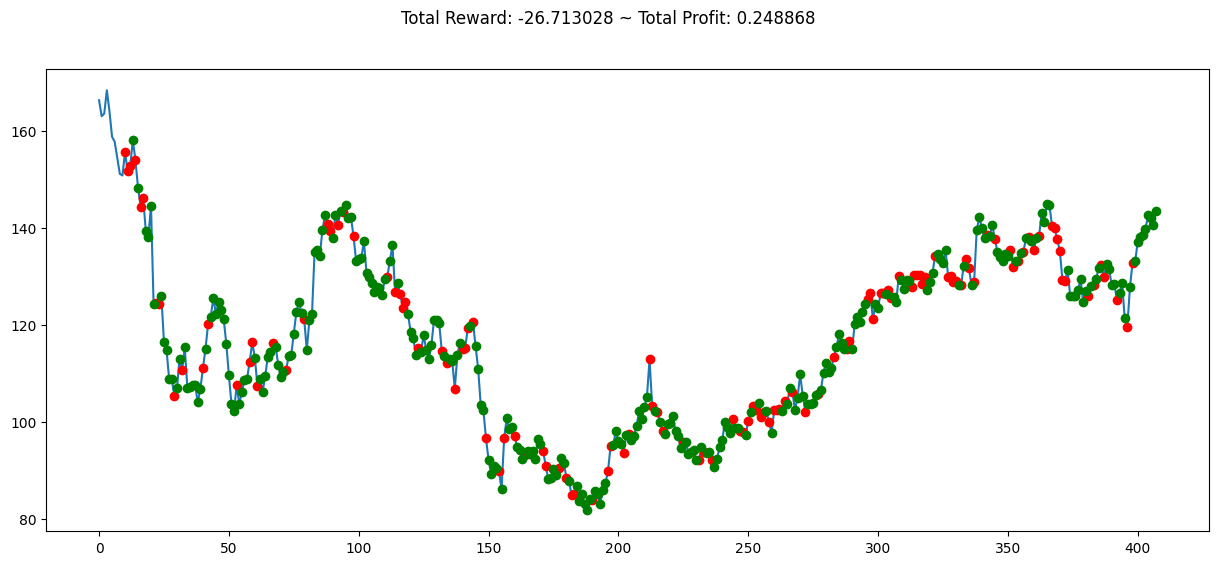

In [35]:
TestModelBuilder.test_model()

In [16]:
GMEStockData = StockData(ticker="GME",
                        start_date="03/16/2020",
                        end_date="03/12/2021",
                        interval="1d")

In [18]:
indicators = [
    lambda df: (ta.sma(close=df['close'], length=12), "SMA_12"),
    lambda df: (ta.rsi(close=df['close']), "RSI"),
    lambda df: (ta.obv(close=df['close'], volume=df['volume']), "OBV")
]
gme_transformed_data = GMEStockData.add_indicators_to_data(indicators=indicators)

In [20]:
GMEModel = ModelBuilder(df=gme_transformed_data,
                        window_size=12,
                        train_percentage=0.8,
                        eval_callback_freq=100000,
                        model_save_path=model_save_path / 'gme_model')

Using cuda device


In [ ]:
GMEModel.train_model(timesteps=1000000)

info {'total_reward': 38.265000343322754, 'total_profit': 6.626410762478355, 'position': <Positions.Short: 0>}


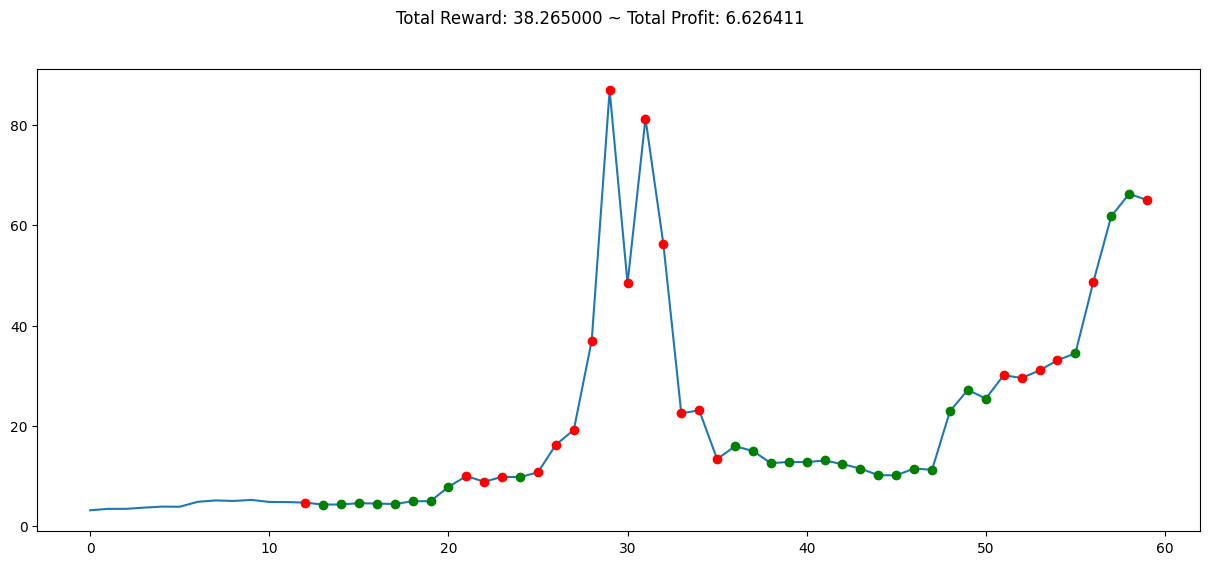

In [33]:
GMEModel.test_model()